In [1]:
import os
import cv2
import json
import numpy as np
from typing import Tuple, Dict, Union
import matplotlib.pyplot as plt

from extensions import IMAGE_EXTENSIONS
from jsonenc import ExtendedEncoder
from files import FileName

In [2]:
image_dir = 'chessboard'
pattern_size = (10, 7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [3]:
image_list = os.listdir(image_dir)
image_path = os.path.join(image_dir, image_list[0])
print(f"image path: {image_path}")

image path: chessboard/DSC00008.JPG


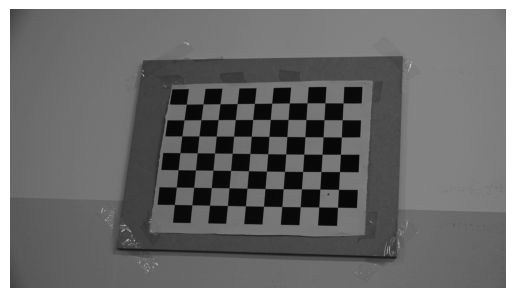

In [4]:
gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots()
ax.imshow(gray, cmap='gray')
ax.axis('off')
plt.show()

In [5]:
ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
print(f"ret: {ret}")
print(f"corners: {corners.shape}")

ret: True
corners: (70, 1, 2)


In [6]:
corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

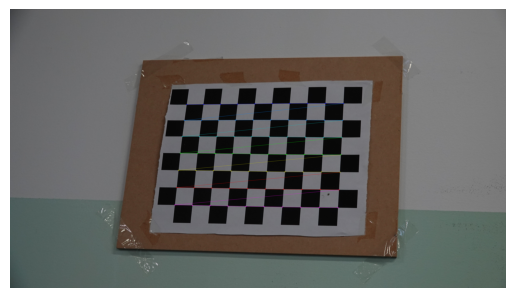

In [7]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.drawChessboardCorners(img, pattern_size, corners, ret)

fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')
plt.show()

In [8]:
def intrinsics_calibration(
    image_dir: str,
    pattern_size: Tuple[int, int] = (10, 7),
    result_dir: str = None,
    save_coords: bool = False,
    ) -> Dict[str, Union[float, int]]:
    
    if result_dir is not None and not os.path.exists(result_dir):
        os.makedirs(result_dir, exist_ok=True)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

    objpoints = []
    imgpoints = []
    calibrated_cnt = 0
    h, w = None, None

    for file in os.listdir(image_dir):
        ex = file.split('.')[-1]
        if ex not in IMAGE_EXTENSIONS:
            continue
        print(f'\rProcessing: {calibrated_cnt}', end='')

        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        if h is None or w is None:
            h, w = img.shape[:2]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        
        if not ret:
            continue

        objpoints.append(objp)
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)

        if result_dir is not None:
            cv2.drawChessboardCorners(img, pattern_size, corners, ret)
            save_path = os.path.join(result_dir, f'calib_{file}.jpg')
            cv2.imwrite(save_path, img)

        calibrated_cnt += 1
    
    print(f'\nCalibrated {calibrated_cnt} images')

    if len(objpoints) == 0 or len(imgpoints) == 0:
        raise ValueError('No calibration data found')
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

    calibration_data = dict(
        mtx = mtx,
        dist = dist,
        rvecs = rvecs,
        tvecs = tvecs,
        new_camera_matrix = new_camera_matrix,
        roi = roi,
    )

    if save_coords:
        coordinates_data = dict(
            objpoints = objpoints,
            imgpoints = imgpoints,
            pattern_size = pattern_size,
        )
        save_path = os.path.join(result_dir, FileName.coordinates_data)
        with open(save_path, 'w') as f:
            json.dump(coordinates_data, f, indent=4, cls=ExtendedEncoder)
        print('Calibration data saved to', save_path)
    
    return calibration_data

In [9]:
image_dir = "chessboard"
calibration_data = intrinsics_calibration(image_dir)

save_path = os.path.join(os.getcwd(), FileName.calibration_data)
with open(save_path, 'w') as f:
    json.dump(calibration_data, f, indent=4, cls=ExtendedEncoder)

print('Calibration data saved to', save_path)

Processing: 32
Calibrated 33 images
Calibration data saved to /home/kitano/3d_tutorial/calibration_data.json
